In [2]:
import parametros
import datos
import fondo
import probs
import init
import resultados

import numpy as np
import pandas as pd
import scipy
import pylab as plt
import matplotlib as mpl
import seaborn as sns
sns.set(style="ticks", context="poster")

from sklearn.mixture import GaussianMixture

import astropy
from astropy.io import fits
from astropy.table import Table
import astropy.coordinates as ac
_ = ac.galactocentric_frame_defaults.set('v4.0') #set the default Astropy Galactocentric frame parameters to the values adopted in Astropy v4.0
import astropy.units as u
import gala.coordinates as gc
import galstreams
from pyia import GaiaData

import os #Avoids issues with paralellization in emcee
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import Pool
from multiprocessing import cpu_count
import datetime, time
import emcee
import corner	

In [3]:
Start = datetime.datetime.now()

print('Inicio: ', Start, '\n')

tabla, st, Name, do_xd_model, N_lim, i_best_xd, C_int, d_mean, e_d_mean, lim_unif, nwalkers, ndim, steps, burn_in, thin, q_lim, d_lim, ra_lim, dec_lim = parametros.parametros()
data, phi1_t, phi2_t, pmphi1_t, pmphi2_t, phi1, phi2, pmphi1, pmphi2, pmra, pmdec, d, pmphi1_reflex, pmphi2_reflex, mu, sigma, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, pmra_pmdec_corr_out, e_d_out, C_pm_radec, C_tot, footprint, mask = datos.datos(tabla, st, Name, C_int, d_mean, d_lim, ra_lim, dec_lim)
# data, phi1_t, phi2_t, pmphi1_t, pmphi2_t, phi1, phi2, pmphi1, pmphi2, pmra, pmdec, d, pmphi1_reflex, pmphi2_reflex, mu, sigma, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, pmra_pmdec_corr_out, e_d_out, C_pm_radec, C_tot, footprint, mask  = datos.datos_gaia(tabla, st, Name, C_int, d_mean, d_lim, ra_lim, dec_lim)
# data, phi1_t, phi2_t, pmphi1_t, pmphi2_t, phi1, phi2, pmphi1, pmphi2, pmra, pmdec, d, pmphi1_reflex, pmphi2_reflex, mu, sigma, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, pmra_pmdec_corr_out, e_d_out, C_pm_radec, C_tot, footprint, mask = datos.datos_gaiaDR3(tabla, st, Name, C_int, d_mean, d_lim, ra_lim, dec_lim)

theta_true = np.array([3.740, 0.686, 22.022, 4.102e-2, -2.826e-2, 9.460e-3, -6.423e-4, 2.832e-3, -6.327e-3, -1.072, -10.954, -16.081, 27/footprint.sum()])

# miembro_PW = (data['Track'][mask]==1) & (data['Memb'][mask]>0.5)
# phi1_PW = phi1[miembro_PW]
# phi2_PW = phi2[miembro_PW]
# pmphi1_PW = pmphi1[miembro_PW]
# pmphi2_PW = pmphi2[miembro_PW]
# d_PW = d[miembro_PW]

#Parametros de la corriente
y = np.array([pmphi1.value, pmphi2.value, d])

#Parametros para el prior gaussiano de los movimientos propios en el frame de la corriente
e_dd = e_d_mean*5

Inicio:  2023-05-26 09:03:21.668342 


Cargando datos 

Cargando track y transformando coordenadas 

Initializing galstreams library from master_log... 


In [3]:
do_xd_model='no'

if do_xd_model=='si':
    N = np.arange(N_lim[0], N_lim[1]) #Vector con numero de gaussianas
    i_best_xd = fondo.XD_minBIC(N, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, e_d_out)

In [3]:
gmm_best = fondo.fondo(i_best_xd, pmra_out, pmdec_out, d_out)#, e_pmra_out, e_pmdec_out, e_d_out)
gmm_name = 'gmm_bg'
np.save(gmm_name + '_weights', gmm_best.weights_, allow_pickle=False)
np.save(gmm_name + '_means', gmm_best.means_, allow_pickle=False)
np.save(gmm_name + '_covariances', gmm_best.covariances_, allow_pickle=False)
    

# xdgmm = fondo.fondo_xd(i_best_xd, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, pmra_pmdec_corr_out, e_d_out)



Calculando modelo de fondo 
GMM_6 converge: True


In [4]:
ll_bgn = gmm_best.score_samples(np.vstack([pmra, pmdec, d]).T) #ln_likelihood del fondo para cada estrella n
# np.save('ll_bgn_inf.npy', ll_bgn)

ll_bgn


# C_obs_radec = np.zeros((len(pmra),3,3))
# C_obs_radec[:,:2,:2] = C_pm_radec
# C_obs_radec[:,2,2] = (d*0.03)**2
# ll_bgn_xd = scipy.special.logsumexp(xdgmm.logprob_a(np.vstack([pmra, pmdec, d]).T, C_obs_radec), axis=-1) #ln_likelihood del fondo para cada estrella n

# print(ll_bgn_xd)

array([-7.0334121 , -6.7702646 , -6.94123739, ..., -9.39118693,
       -9.53278581, -7.58777342])

In [5]:
#Para que funcione tengo que primero asignarle las variables globales al modulo probs
steps = 2**16
thin = 1100
# 17 2200
# 16 1100
# 15 550
# 14 225
# 13 112
# 12 56

emcee_mask = footprint

probs.phi1 = phi1[emcee_mask]
probs.y = y[:,emcee_mask]
probs.C_tot = C_tot[emcee_mask]
probs.ll_bgn = ll_bgn[emcee_mask]

probs.mu = mu
probs.sigma = sigma
probs.d_mean = d_mean
probs.e_dd = e_dd
probs.lim_unif = lim_unif


ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

pos0, _ = init.init_ls(phi1, pmphi1, pmphi2, d, footprint, nwalkers, ndim) #Inicializo haciendo minimos cuadrados con las estrellas que ya se que son miembros segun PW2019


#NCPU RUN
dtype = [("(arg1, arg2)", object)]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, probs.ln_posterior, pool=pool, blobs_dtype=dtype)#, args=(mu, sigma, d_mean, e_dd, lim_unif))
    start = time.time()
    pos, _, _, _ = sampler.run_mcmc(pos0, burn_in, progress=True)
    sampler.reset()
    pos_final, _, _, _ = sampler.run_mcmc(pos, steps, progress=True)
    end = time.time()
    multi_time = end-start 
    print('Tiempo MCMC: ', datetime.timedelta(seconds=multi_time), 'hrs')#,serial_time/multi_time)

16 CPUs


  1%|█▏                                                                                                                                                 | 8/1024 [00:00<00:31, 32.63it/s]

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2



  1%|█▋                                                                                                                                                | 12/1024 [00:00<00:31, 32.01it/s]

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2



  2%|██▎                                                                                                                                               | 16/1024 [00:00<00:32, 30.57it/s]

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2



  2%|██▊                                                                                                                                               | 20/1024 [00:00<00:32, 30.55it/s]

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2



  2%|███▍                                                                                                                                              | 24/1024 [00:00<00:33, 30.22it/s]

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2



  3%|████▍                                                                                                                                             | 31/1024 [00:01<00:33, 29.85it/s]

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2



  5%|██████▋                                                                                                                                           | 47/1024 [00:01<00:32, 30.13it/s]

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2



  5%|███████▎                                                                                                                                          | 51/1024 [00:01<00:32, 30.29it/s]

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2



  6%|████████▍                                                                                                                                         | 59/1024 [00:01<00:31, 30.31it/s]

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2



 13%|██████████████████▌                                                                                                                              | 131/1024 [00:04<00:27, 32.03it/s]

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:63: RuntimeWarning: invalid value encountered in log
  arg1 = np.log(f) + lnlike_st(theta)

/home/bruno/Documents/Maestria/stream_memb/Price+2019/probs.py:66: RuntimeWarning: invalid value encountered in logaddexp
  return np.sum(np.logaddexp(arg1, arg2)), arg1, arg2



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65536/65536 [41:37<00:00, 26.24it/s]

Tiempo MCMC:  0:42:13.323656 hrs


In [6]:
flat_samples = sampler.get_chain(discard=0, thin=thin, flat=True)
print('Tamano muestra: {}'.format(flat_samples.shape))

columns = ["$a_{\mu_{\phi_1}}$", "$a_{\mu_{\phi_2}}$", "$a_d$", "$b_{\mu_{\phi_1}}$", "$b_{\mu_{\phi_2}}$", "$b_d$", "$c_{\mu_{\phi_1}}$", "$c_{\mu_{\phi_2}}$", "$c_d$", "$x_{\mu_{\phi_1}}$", "$x_{\mu_{\phi_2}}$", "$x_d$", "f"]
theta_post = pd.DataFrame(flat_samples, columns=columns)

print('Guardando muestras \n')

##Guardo las posteriors
ln_post = sampler.get_log_prob(discard=0, thin=thin, flat=True)
post_true, _ = probs.ln_posterior(theta_true)

theta_post['ln_posterior'] = ln_post
theta_post.to_csv('theta_post.csv', index=False)

flat_samples = np.insert(flat_samples, flat_samples.shape[1], np.array(ln_post), axis=1)

Tamano muestra: (6136, 13)
Guardando muestras 



In [4]:
#Datos del archivo viejo (GaiaDR2)

from astropy.table import Table
import astropy.coordinates as ac
_ = ac.galactocentric_frame_defaults.set('v4.0') #set the default Astropy Galactocentric frame parameters to the values adopted in Astropy v4.0
import astropy.units as u
from astropy.io import fits
import gala.coordinates as gc
import galstreams

mwsts = galstreams.MWStreams(verbose=False, implement_Off=True)

data, phi1_t, phi2_t, pmphi1_t, pmphi2_t, phi1, phi2, pmphi1, pmphi2, pmra, pmdec, d, pmphi1_reflex, pmphi2_reflex, mu, sigma, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, pmra_pmdec_corr_out, e_d_out, C_pm_radec, C_tot, footprint, mask = datos.datos(tabla, st, Name, C_int, d_mean, d_lim, ra_lim, dec_lim)
y = np.array([pmphi1.value, pmphi2.value, d])

C_obs = C_tot - C_int
e_pmphi1 = np.array([C_obs[i][0,0]**0.5 for i in range(len(phi1))])
e_pmphi2 = np.array([C_obs[i][1,1]**0.5 for i in range(len(phi1))])
e_d = np.array([C_obs[i][2,2]**0.5 for i in range(len(phi1))])

gmm_name = 'gmm_bg'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
gmm_best = GaussianMixture(n_components = len(means), covariance_type='full')
gmm_best.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
gmm_best.weights_ = np.load(gmm_name + '_weights.npy')
gmm_best.means_ = means
gmm_best.covariances_ = covar

ll_bgn = gmm_best.score_samples(np.vstack([pmra, pmdec, d]).T) #ln_likelihood del fondo para cada estrella n
# np.save('ll_bgn_memb.npy', ll_bgn)
# ll_bgn = np.load('ll_bgn_memb.npy')

skypath = np.loadtxt('pal5_extended_skypath.icrs.txt')
skypath_N = ac.SkyCoord(ra=skypath[:,0]*u.deg, dec=skypath[:,1]*u.deg, frame='icrs')
skypath_S = ac.SkyCoord(ra=skypath[:,0]*u.deg, dec=skypath[:,2]*u.deg, frame='icrs')

# Concatenate N track, S-flipped track and add first point at the end to close the polygon (needed for ADQL)
on_poly = ac.SkyCoord(ra = np.concatenate((skypath_N.ra,skypath_S.ra[::-1],skypath_N.ra[:1])),
                        dec = np.concatenate((skypath_N.dec,skypath_S.dec[::-1],skypath_N.dec[:1])),
                        unit=u.deg, frame='icrs')
# on_poly = mwsts['Pal5-S20'].create_sky_polygon_footprint_from_track(width=1.5*u.deg, phi2_offset=-0.1*u.deg)

field = ac.SkyCoord(ra=data[mask]['RA_ICRS']*u.deg, dec=data[mask]['DE_ICRS']*u.deg, frame='icrs')
footprint = galstreams.get_mask_in_poly_footprint(on_poly, field, stream_frame=mwsts[st].stream_frame)


f = fits.open('RRLwithprobthin.fit')
data_PW = f[1].data
c = ac.ICRS(ra=data_PW['RA_ICRS']*u.degree, dec=data_PW['DE_ICRS']*u.degree, distance=data_PW['Dist']*u.kpc, pm_ra_cosdec=data_PW['pmRA']*u.mas/u.yr, pm_dec=data_PW['pmDE']*u.mas/u.yr, radial_velocity=np.zeros(len(data_PW['pmRA']))*u.km/u.s) 
st_coord = c.transform_to(mwsts[st].stream_frame)

miembro_PW = (data_PW['Track']==1) & (data_PW['Memb']>0.5)
# theta_true = np.array([3.740, 0.686, 22.022, 4.102e-2, -2.826e-2, 9.460e-3, -6.423e-4, 2.832e-3, -6.327e-3, -1.072, -10.954, -16.081, 0.2])

phi1_PW = st_coord.phi1[miembro_PW] #deg
phi2_PW = st_coord.phi2[miembro_PW] #deg
pmphi1_PW = st_coord.pm_phi1_cosphi2[miembro_PW] #mas/yr
pmphi2_PW = st_coord.pm_phi2[miembro_PW] #mas/yr
d_PW = data_PW[miembro_PW]['Dist'] #kpc

Initializing galstreams library from master_log... 

Cargando datos 

Cargando track y transformando coordenadas 

Initializing galstreams library from master_log... 


In [10]:
#Datos del archivo nuevo (GaiaDR2)

from astropy.io import fits
from astropy.table import Table
import astropy.coordinates as ac
_ = ac.galactocentric_frame_defaults.set('v4.0') #set the default Astropy Galactocentric frame parameters to the values adopted in Astropy v4.0
import astropy.units as u
import gala.coordinates as gc
import galstreams

mwsts = galstreams.MWStreams(verbose=False, implement_Off=True)

data, phi1_t, phi2_t, pmphi1_t, pmphi2_t, phi1, phi2, pmphi1, pmphi2, pmra, pmdec, d, pmphi1_reflex, pmphi2_reflex, mu, sigma, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, pmra_pmdec_corr_out, e_d_out, C_pm_radec, C_tot, footprint, mask  = datos.datos_gaia(tabla, st, Name, C_int, d_mean, d_lim, ra_lim, dec_lim)
y = np.array([pmphi1.value, pmphi2.value, d])

C_obs = C_tot - C_int
e_pmphi1 = np.array([C_obs[i][0,0]**0.5 for i in range(len(phi1))])
e_pmphi2 = np.array([C_obs[i][1,1]**0.5 for i in range(len(phi1))])
e_d = np.array([C_obs[i][2,2]**0.5 for i in range(len(phi1))])



gmm_name = 'gmm_bg'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
gmm_best = GaussianMixture(n_components = len(means), covariance_type='full')
gmm_best.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
gmm_best.weights_ = np.load(gmm_name + '_weights.npy')
gmm_best.means_ = means
gmm_best.covariances_ = covar

ll_bgn = gmm_best.score_samples(np.vstack([pmra, pmdec, d]).T) #ln_likelihood del fondo para cada estrella n
# np.save('ll_bgn_memb.npy', ll_bgn)
# ll_bgn = np.load('ll_bgn_memb.npy')


skypath = np.loadtxt('pal5_extended_skypath.icrs.txt')
skypath_N = ac.SkyCoord(ra=skypath[:,0]*u.deg, dec=skypath[:,1]*u.deg, frame='icrs')
skypath_S = ac.SkyCoord(ra=skypath[:,0]*u.deg, dec=skypath[:,2]*u.deg, frame='icrs')

# Concatenate N track, S-flipped track and add first point at the end to close the polygon (needed for ADQL)
on_poly = ac.SkyCoord(ra = np.concatenate((skypath_N.ra,skypath_S.ra[::-1],skypath_N.ra[:1])),
                        dec = np.concatenate((skypath_N.dec,skypath_S.dec[::-1],skypath_N.dec[:1])),
                        unit=u.deg, frame='icrs')
# on_poly = mwsts['Pal5-S20'].create_sky_polygon_footprint_from_track(width=1.5*u.deg, phi2_offset=-0.1*u.deg)

field = ac.SkyCoord(ra=data[mask].ra*u.deg, dec=data[mask].dec*u.deg, frame='icrs')
footprint = galstreams.get_mask_in_poly_footprint(on_poly, field, stream_frame=mwsts[st].stream_frame)


f = fits.open('RRLwithprobthin.fit')
data_PW = f[1].data
c = ac.ICRS(ra=data_PW['RA_ICRS']*u.degree, dec=data_PW['DE_ICRS']*u.degree, distance=data_PW['Dist']*u.kpc, pm_ra_cosdec=data_PW['pmRA']*u.mas/u.yr, pm_dec=data_PW['pmDE']*u.mas/u.yr, radial_velocity=np.zeros(len(data_PW['pmRA']))*u.km/u.s) 
st_coord = c.transform_to(mwsts[st].stream_frame)

miembro_PW = (data_PW['Track']==1) & (data_PW['Memb']>0.5)
# theta_true = np.array([3.740, 0.686, 22.022, 4.102e-2, -2.826e-2, 9.460e-3, -6.423e-4, 2.832e-3, -6.327e-3, -1.072, -10.954, -16.081, 0.2])

phi1_PW = st_coord.phi1[miembro_PW] #deg
phi2_PW = st_coord.phi2[miembro_PW] #deg
pmphi1_PW = st_coord.pm_phi1_cosphi2[miembro_PW] #mas/yr
pmphi2_PW = st_coord.pm_phi2[miembro_PW] #mas/yr
d_PW = data_PW[miembro_PW]['Dist'] #kpc


Initializing galstreams library from master_log... 

Cargando datos 

Cargando track y transformando coordenadas 

Initializing galstreams library from master_log... 


In [4]:
#Datos de GaiaDR3

# from astropy.io import fits
# from astropy.table import Table
# import astropy.coordinates as ac
# _ = ac.galactocentric_frame_defaults.set('v4.0') #set the default Astropy Galactocentric frame parameters to the values adopted in Astropy v4.0
# import astropy.units as u
# import gala.coordinates as gc
# import galstreams
# from pyia import GaiaData


mwsts = galstreams.MWStreams(verbose=False, implement_Off=True)

data, phi1_t, phi2_t, pmphi1_t, pmphi2_t, phi1, phi2, pmphi1, pmphi2, pmra, pmdec, d, pmphi1_reflex, pmphi2_reflex, mu, sigma, pmra_out, pmdec_out, d_out, e_pmra_out, e_pmdec_out, pmra_pmdec_corr_out, e_d_out, C_pm_radec, C_tot, footprint, mask = datos.datos_gaiaDR3(tabla, st, Name, C_int, d_mean, d_lim, ra_lim, dec_lim)
y = np.array([pmphi1.value, pmphi2.value, d])

C_obs = C_tot - C_int
e_pmphi1 = np.array([C_obs[i][0,0]**0.5 for i in range(len(phi1))])
e_pmphi2 = np.array([C_obs[i][1,1]**0.5 for i in range(len(phi1))])
e_d = np.array([C_obs[i][2,2]**0.5 for i in range(len(phi1))])

gmm_name = 'gmm_bg'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
gmm_best = GaussianMixture(n_components = len(means), covariance_type='full')
gmm_best.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
gmm_best.weights_ = np.load(gmm_name + '_weights.npy')
gmm_best.means_ = means
gmm_best.covariances_ = covar

ll_bgn = gmm_best.score_samples(np.vstack([pmra, pmdec, d]).T) #ln_likelihood del fondo para cada estrella n
# np.save('ll_bgn_memb.npy', ll_bgn)
# ll_bgn = np.load('ll_bgn_memb.npy')

# skypath = np.loadtxt('pal5_extended_skypath.icrs.txt')
# skypath_N = ac.SkyCoord(ra=skypath[:,0]*u.deg, dec=skypath[:,1]*u.deg, frame='icrs')
# skypath_S = ac.SkyCoord(ra=skypath[:,0]*u.deg, dec=skypath[:,2]*u.deg, frame='icrs')

# # Concatenate N track, S-flipped track and add first point at the end to close the polygon (needed for ADQL)
# on_poly = ac.SkyCoord(ra = np.concatenate((skypath_N.ra,skypath_S.ra[::-1],skypath_N.ra[:1])),
#                         dec = np.concatenate((skypath_N.dec,skypath_S.dec[::-1],skypath_N.dec[:1])),
#                         unit=u.deg, frame='icrs')
on_poly = mwsts['Pal5-S20'].create_sky_polygon_footprint_from_track(width=1.5*u.deg, phi2_offset=-0.1*u.deg)

field = ac.SkyCoord(ra=data.ra, dec=data.dec, frame='icrs')
footprint = galstreams.get_mask_in_poly_footprint(on_poly, field, stream_frame=mwsts[st].stream_frame)


f = fits.open('RRLwithprobthin.fit')
data_PW = f[1].data
c = ac.ICRS(ra=data_PW['RA_ICRS']*u.degree, dec=data_PW['DE_ICRS']*u.degree, distance=data_PW['Dist']*u.kpc, pm_ra_cosdec=data_PW['pmRA']*u.mas/u.yr, pm_dec=data_PW['pmDE']*u.mas/u.yr, radial_velocity=np.zeros(len(data_PW['pmRA']))*u.km/u.s) 
st_coord = c.transform_to(mwsts[st].stream_frame)

miembro_PW = (data_PW['Track']==1) & (data_PW['Memb']>0.5)
# theta_true = np.array([3.740, 0.686, 22.022, 4.102e-2, -2.826e-2, 9.460e-3, -6.423e-4, 2.832e-3, -6.327e-3, -1.072, -10.954, -16.081, 0.2])

phi1_PW = st_coord.phi1[miembro_PW] #deg
phi2_PW = st_coord.phi2[miembro_PW] #deg
pmphi1_PW = st_coord.pm_phi1_cosphi2[miembro_PW] #mas/yr
pmphi2_PW = st_coord.pm_phi2[miembro_PW] #mas/yr
d_PW = data_PW[miembro_PW]['Dist'] #kpc


Initializing galstreams library from master_log... 

Cargando datos 

Initializing galstreams library from master_log... 
/home/bruno/anaconda3/lib/python3.9/site-packages/astropy/io/ascii/fastbasic.py:128: AstropyWarning: OverflowError converting to FloatType in column Dist_M18_sfdAG, possibly resulting in degraded precision.
  data, comments = self.engine.read(try_int, try_float, try_string)

/home/bruno/anaconda3/lib/python3.9/site-packages/astropy/io/ascii/fastbasic.py:128: AstropyWarning: OverflowError converting to FloatType in column Dist_M18_sfdAG_err, possibly resulting in degraded precision.
  data, comments = self.engine.read(try_int, try_float, try_string)

/home/bruno/anaconda3/lib/python3.9/site-packages/astropy/io/ascii/fastbasic.py:128: AstropyWarning: OverflowError converting to FloatType in column Dist, possibly resulting in degraded precision.
  data, comments = self.engine.read(try_int, try_float, try_string)

/home/bruno/anaconda3/lib/python3.9/site-packages/astrop

In [5]:
flat_samples = pd.read_csv('theta_post.csv').to_numpy()
ln_post = flat_samples[:,13]
Memb = pd.read_csv('memb_prob.csv')
memb = Memb['Memb']
inside10 = Memb['inside10']
inside50 = Memb['inside50']

In [9]:
probs.phi1 = phi1
probs.y = y
probs.C_tot = C_tot
probs.ll_bgn = ll_bgn

mask_post = flat_samples[:,ndim] > -np.inf

flat_blobs = resultados.flat_blobs(flat_samples, ll_bgn, ndim) #Lo que demora inf es esta parte
memb = resultados.memb_cont(phi1, flat_blobs)

inside10 = memb > 0.1 
inside50 = memb > 0.5

Memb = pd.DataFrame({'SolID': data[mask]['SolID'], 'DR2Name': data[mask]['DR2Name'], 'Memb': memb,'inside10': inside10, 'inside50': inside50})
# Memb = pd.DataFrame({'SolID': data['solution_id'], 'DR2Name': data['designation'], 'Memb': memb,'inside10': inside10, 'inside50': inside50})
Memb.to_csv('memb_prob.csv', index=False)

In [10]:
# t1 = Table.read('Odenkirchen2002_gaia.csv')
# t2 = Table.read('Odenkirchen2009_gaia.csv')
# Oden = astropy.table.vstack((t1, t2))
# Oden.rename_column('ra','ra_O')
# Oden.rename_column('dec','dec_O')
# Oden.rename_column('RAdeg','ra')
# Oden.rename_column('DEdeg','dec')
# Oden.rename_column('e_RAdeg','ra_error')
# Oden.rename_column('e_DEdeg','dec_error')
# Oden.rename_column('pmRA', 'pmra')
# Oden.rename_column('pmDE', 'pmdec')
# Oden.rename_column('e_pmRA', 'pmra_error')
# Oden.rename_column('e_pmDE', 'pmdec_error')
# Oden.rename_column('pmRApmDEcor', 'pmra_pmdec_corr')

# g_oden = GaiaData(Oden)
# g_oden = g_oden[(g_oden.vr_a > -80) & (g_oden.vr_a < -20) & (g_oden.pmra > -5*u.mas/u.yr)]
# g_oden = g_oden[(g_oden.vr_a > -66) & (g_oden.vr_a < -50) & (g_oden.ra < 232*u.deg)]
# g_oden.data['Dist'] = 21. # HACK
# g_oden.data['Dist_err'] = 10. # HACK

# c_oden = g_oden.get_skycoord(distance=g_oden.Dist*u.kpc, radial_velocity = np.zeros(len(g_oden.Dist))*u.km/u.s)
# c_oden_pal5 = c_oden.transform_to(mwsts[st].stream_frame)

In [7]:
p5stars = Table.read('pla5stars_gapzo_dist.csv')
p5stars = GaiaData(p5stars)

c_p5stars = p5stars.get_skycoord(distance=p5stars.Dist*u.kpc, radial_velocity = np.zeros(len(p5stars.Dist))*u.km/u.s)
c_p5stars_pal5 = c_p5stars.transform_to(mwsts[st].stream_frame)

theta_true: 
 [ 3.74000000e+00  6.86000000e-01  2.20220000e+01  4.10200000e-02
 -2.82600000e-02  9.46000000e-03 -6.42300000e-04  2.83200000e-03
 -6.32700000e-03 -1.07200000e+00 -1.09540000e+01 -1.60810000e+01
  2.47706422e-01] 

inside10_PW:  89
inside50_PW:  57
star_PW:  27 

theta_max: 
 [ 3.80564361e+00  7.24234897e-01  2.08595561e+01  6.27744809e-02
  2.23611893e-02 -1.60101555e-01  5.26689343e-04  1.95566567e-03
 -6.07568013e-03  3.14253347e-01 -4.04459423e-01 -1.29625976e+00
  2.42810406e-01 -6.39493742e+02]

Guardando resultados 

Graficando resultados 

Inside10:  93
Inside50:  61
Stars:  26

Estrellas miembro:
Iguales:  25
Faltan:  2
Extras:  1


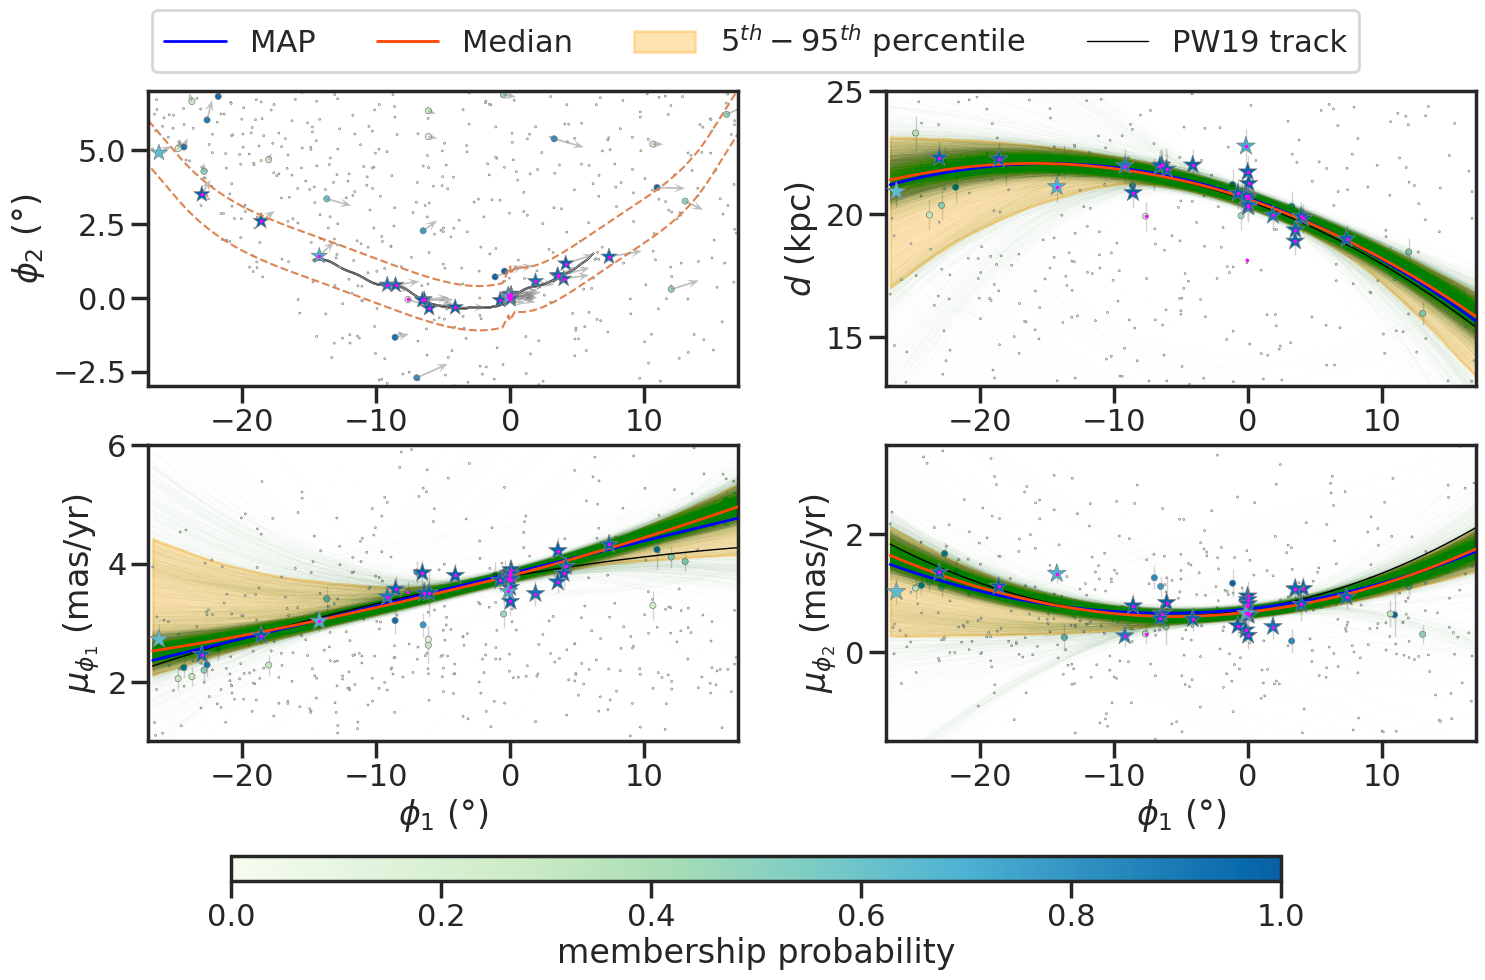

In [7]:
print('theta_true: \n', theta_true,'\n')
print('inside10_PW: ', (data_PW['Memb']>0.1).sum())
print('inside50_PW: ', (data_PW['Memb']>0.5).sum())
print('star_PW: ', miembro_PW.sum(),'\n')


# skypath = np.loadtxt('pal5_extended_skypath.icrs.txt')
# skypath_N = ac.SkyCoord(ra=skypath[:,0]*u.deg, dec=skypath[:,1]*u.deg, frame='icrs')
# skypath_S = ac.SkyCoord(ra=skypath[:,0]*u.deg, dec=skypath[:,2]*u.deg, frame='icrs')

# # Concatenate N track, S-flipped track and add first point at the end to close the polygon (needed for ADQL)
# on_poly = ac.SkyCoord(ra = np.concatenate((skypath_N.ra,skypath_S.ra[::-1],skypath_N.ra[:1])),
#                         dec = np.concatenate((skypath_N.dec,skypath_S.dec[::-1],skypath_N.dec[:1])),
#                         unit=u.deg, frame='icrs')

# mask_post = flat_samples[:,ndim] > -np.inf

n = 500
x = np.linspace(min(phi1.value), max(phi1.value), n)
theta_max, theta_50, theta_qmin, theta_qmax, quantiles_mu1, quantiles_mu2, quantiles_d = resultados.quantiles(x, flat_samples[mask_post]
                                                                                                              , q_lim[0], q_lim[1])
                                                                                                              # ,16,84)
print('theta_max: \n', theta_max)

print('\nGuardando resultados \n')

# theta_resul = pd.DataFrame(columns = ["$a_{\mu1}$", "$a_{\mu2}$", "$a_d$", "$b_{\mu1}$", "$b_{\mu2}$", "$b_d$", "$c_{\mu1}$", "$c_{\mu2}$", "$c_d$", "$x_{\mu1}$", "$x_{\mu2}$", "$x_d$", "f", "Posterior"])
# theta_resul.loc[0] = theta_max
# theta_resul.loc[1] = theta_50
# theta_resul.loc[2] = theta_qmin
# theta_resul.loc[3] = theta_qmax
# theta_resul.index = ['MAP','median','{}th'.format(q_lim[0]),'{}th'.format(q_lim[1])]
# theta_resul.to_csv('theta_resul.csv', index=True)



#MAP
y_mu1 = init.model(x, theta_max[0], theta_max[3], theta_max[6], theta_max[9])
y_mu2 = init.model(x, theta_max[1], theta_max[4], theta_max[7], theta_max[10])
y_d = init.model(x, theta_max[2], theta_max[5], theta_max[8], theta_max[11])

#true
true_mu1 = init.model(x, theta_true[0], theta_true[3], theta_true[6], theta_true[9])
true_mu2 = init.model(x, theta_true[1], theta_true[4], theta_true[7], theta_true[10])
true_d = init.model(x, theta_true[2], theta_true[5], theta_true[8], theta_true[11])



print('Graficando resultados \n')

inside = inside10
star = (inside50==True) & (footprint==True)

phi1_lim = (-27,17)
phi2_lim = (-3,7)

xy_mask = (phi1.value>=phi1_lim[0]) & (phi1.value<phi1_lim[1]) & (phi2.value>=phi2_lim[0]) & (phi2.value<=phi2_lim[1])
xy_mask_PW = (st_coord.phi1.value>=phi1_lim[0]) & (st_coord.phi1.value<phi1_lim[1]) & (st_coord.phi2.value>=phi2_lim[0]) & (st_coord.phi2.value<=phi2_lim[1])


print('Inside10: ', inside.sum())
print('Inside50: ', inside50.sum())
print('Stars: ', star.sum())


bla = np.zeros(len(phi1_PW))#[None for i in range(len(phi1_PW))]
for i in range(len(phi1_PW)):
    for j in range(len(phi1[star])):
        if (np.sort(phi1_PW)[i]<0) & (np.sort(phi1_PW)[i]<np.sort(phi1[star])[j]*0.99) & (np.sort(phi1_PW)[i]>np.sort(phi1[star])[j]*1.01):
            bla[i] = 1
            # print((i,j))
        if (np.sort(phi1_PW)[i]>0) & (np.sort(phi1_PW)[i]>np.sort(phi1[star])[j]*0.99) & (np.sort(phi1_PW)[i]<np.sort(phi1[star])[j]*1.01):
            bla[i] = 1
            # print((i,j))

print('\nEstrellas miembro:')
print('Iguales: ', int(bla.sum()))
print('Faltan: ', 27-int(bla.sum()))
print('Extras: ', int(star.sum() - bla.sum()))



def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = truncate_colormap(plt.get_cmap('GnBu'), minval=0, maxval=0.9) #'GnBu'

parabola = True

poly_S20 = mwsts['Pal5-S20'].create_sky_polygon_footprint_from_track(width=1.5*u.deg, phi2_offset=-0.1*u.deg)

# st_track = mwsts['Pal5-S20'].track.transform_to(mwsts[st].stream_frame)
# phi1_t = st_track.phi1
# phi2_t = st_track.phi2


#Errores en pmphi, y d
C_obs = C_tot - C_int
e_pmphi1 = np.array([C_obs[i][0,0]**0.5 for i in range(len(phi1))])
e_pmphi2 = np.array([C_obs[i][1,1]**0.5 for i in range(len(phi1))])
e_d = np.array([C_obs[i][2,2]**0.5 for i in range(len(phi1))])



fig=plt.figure(1,figsize=(15,10))    
fig.subplots_adjust(wspace=0.25,hspace=0.2,top=0.9,bottom=0.25,left=0.095,right=0.98)

ax=fig.add_subplot(221)
ax.scatter(phi1[~inside], phi2[~inside], s=2, c=memb[~inside], cmap=cmap, edgecolors='gray', linewidths=0.5, vmin=0., vmax=1.)
ax.scatter(phi1[inside], phi2[inside], s=20, c=memb[inside], cmap=cmap, edgecolors='gray', linewidths=0.5, vmin=0., vmax=1.)
ax.quiver(phi1.value[inside], phi2.value[inside], pmphi1_reflex.value[inside], pmphi2_reflex.value[inside], color='gray', width=0.003, headwidth=5, headlength=6.5, headaxislength=4, alpha=.5, scale=30)
ax.plot(on_poly.transform_to(mwsts[st].stream_frame).phi1, on_poly.transform_to(mwsts[st].stream_frame).phi2, ls='--', lw=1.5, color='C1')
# ax.plot(mwsts['Pal5-S20'].poly_sc.transform_to(mwsts[st].stream_frame).phi1, mwsts['Pal5-S20'].poly_sc.transform_to(mwsts[st].stream_frame).phi2, ls='--', lw=1., color='green');
# ax.plot(poly_S20.transform_to(mwsts[st].stream_frame).phi1, poly_S20.transform_to(mwsts[st].stream_frame).phi2, ls='--', lw=1., color='magenta');
# ax.plot(mwsts['Pal5-S20'].track.transform_to(mwsts[st].stream_frame).phi1, mwsts['Pal5-S20'].track.transform_to(mwsts[st].stream_frame).phi2, '.', c='black', ms=0.1, zorder=0)#ls='-', lw=1.5, color='green');
ax.plot(phi1_t,phi2_t,'.', c='black', ms=0.1, zorder=0)

ax.plot(phi1_PW, phi2_PW,'.', c='magenta', ms=3., zorder=6)#, label='PW19')#, alpha=0.4)
# ax.plot(c_p5stars_pal5.phi1, c_p5stars_pal5.phi2,'.', c='magenta', ms=3.,zorder=7)#, label='PW19')#, alpha=0.4)
# ax.plot(phi1_PW, phi2_PW,'.', c='black', ms=5., zorder=6)#, alpha=0.4)

# ax.plot(c_oden_pal5.phi1, c_oden_pal5.phi2,'.', c='red', ms=3., zorder=7)#, label='PW19')#, alpha=0.4)
ax.scatter(phi1[star], phi2[star], s=150., c=memb[star], cmap=cmap, marker='*', edgecolors='gray', linewidths=0.5, vmin=0., vmax=1.)#, label='Members')
# ax.plot(st_coord.phi1,st_coord.phi2,'.', c='black', ms=2)
ax.set_ylabel('$\phi_2$ (°)')
ax.set_xlim(phi1_lim)
ax.set_ylim(phi2_lim)
# ax.set_xlim([min(phi1.value),max(phi1.value)])
# ax.set_xlim([-.25,.25])
# ax.set_ylim([-.25,.25])
# ax.set_xlim([-10,10])
# ax.set_ylim([-0.5,1.5])



ax=fig.add_subplot(222)
ax.scatter(phi1[~inside & xy_mask], d[~inside & xy_mask], s=2, c=memb[~inside & xy_mask], cmap=cmap, edgecolors='gray', linewidths=0.5, vmin=0., vmax=1.)
ax.errorbar(x=phi1[inside & xy_mask], y=d[inside & xy_mask], yerr=e_d[inside & xy_mask], lw=0, elinewidth=1, color='lightgray', zorder=0)
ax.scatter(phi1[inside & xy_mask], d[inside & xy_mask], s=20, c=memb[inside & xy_mask], cmap=cmap, edgecolors='gray', linewidths=0.5, vmin=0., vmax=1.)
ax.fill_between(x, quantiles_d[0], quantiles_d[2], color="orange", alpha=0.3, zorder=0)#, label='$5^{th}-95^{th}$')
ax.plot(x, quantiles_d[1], color="orangered", lw=2, zorder=4)
if parabola == True:
    for i in range(flat_samples.shape[0]):
        y_d = init.model(x, flat_samples[i,2], flat_samples[i,5], flat_samples[i,8], flat_samples[i,11])
        ax.plot(x, y_d, lw=.5, color="green", zorder=1, alpha=0.01)
ax.plot(x, y_d, lw=2, color="blue", zorder=3)
ax.plot(x, true_d, lw=1, color="black", zorder=2)

ax.plot(phi1_PW, d_PW,'.', c='magenta', ms=3., zorder=6)#, label='PW19')#, alpha=0.4)
# ax.plot(c_p5stars_pal5.phi1, p5stars.Dist,'.', c='magenta', ms=3,zorder=6.)#, label='PW19')#, alpha=0.4)
# ax.plot(phi1_PW, d_PW,'.', c='black', ms=5., zorder=5)#, alpha=0.4)

# ax.plot(c_oden_pal5.phi1, g_oden.Dist,'.', c='red', ms=3., zorder=7)#, label='PW19')#, alpha=0.4)
ax.scatter(phi1[star], d[star], s=200., c=memb[star], cmap=cmap, marker='*', edgecolors='gray', linewidths=0.5, vmin=0., vmax=1., zorder=5)
# ax.plot(st_coord.phi1[xy_mask_PW],data_PW[xy_mask_PW]['Dist'],'.', c='black', ms=2)
ax.set_ylabel('$d$ (kpc)')
ax.set_xlim(phi1_lim)
ax.set_ylim([13,25])
# ax.set_xlim([min(phi1.value),max(phi1.value)])
# ax.set_ylim([min(d),max(d)])
# ax.set_xlim([-.25,.25])
# ax.set_ylim([20,22])

ax=fig.add_subplot(223)
ax.scatter(phi1[~inside & xy_mask], pmphi1[~inside & xy_mask], s=2, c=memb[~inside & xy_mask], cmap=cmap, edgecolors='gray', linewidths=0.5, vmin=0., vmax=1.)
ax.errorbar(x=phi1[inside & xy_mask], y=pmphi1.value[inside & xy_mask], yerr=e_pmphi1[inside & xy_mask], lw=0, elinewidth=1, color='lightgray', zorder=0)
ax.scatter(phi1[inside & xy_mask], pmphi1[inside & xy_mask], s=20, c=memb[inside & xy_mask], cmap=cmap, edgecolors='gray', linewidths=0.5, vmin=0., vmax=1.)
ax.fill_between(x, quantiles_mu1[0], quantiles_mu1[2], color="orange", alpha=0.3, zorder=0)#, label='$5^{th}-95^{th}$')
ax.plot(x, quantiles_mu1[1], color="orangered", lw=2, zorder=4)
if parabola == True:
    for i in range(flat_samples.shape[0]):
        y_mu1 = init.model(x, flat_samples[i,0], flat_samples[i,3], flat_samples[i,6], flat_samples[i,9])
        ax.plot(x, y_mu1, lw=.5, color="green", alpha=0.01, zorder=1)
ax.plot(x, y_mu1, lw=2, color="blue", zorder=3)
ax.plot(x, true_mu1, lw=1, color="black", zorder=2)

ax.plot(phi1_PW, pmphi1_PW,'.', c='magenta', ms=3., zorder=6)#, label='PW19')#, alpha=0.4)
# ax.plot(c_p5stars_pal5.phi1, c_p5stars_pal5.pm_phi1_cosphi2,'.', c='magenta', ms=3.,zorder=6)#, label='PW19')#, alpha=0.4)
# ax.plot(phi1_PW, pmphi1_PW,'.', c='black', ms=5., zorder=5)#, alpha=0.4)

# ax.plot(c_oden_pal5.phi1, c_oden_pal5.pm_phi1_cosphi2,'.', c='red', ms=3., zorder=7)#, label='PW19')#, alpha=0.4)
ax.scatter(phi1[star], pmphi1[star], s=200., c=memb[star], cmap=cmap, marker='*', edgecolors='gray', linewidths=0.5, vmin=0., vmax=1, zorder=5)#., label='Members')
# ax.plot(st_coord.phi1[xy_mask_PW],st_coord.pm_phi1_cosphi2[xy_mask_PW],'.', c='black', ms=2)
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$\mu_{\phi_1}$ (mas/yr)')
ax.set_xlim(phi1_lim)
ax.set_ylim([1,6])
# ax.set_xlim([min(phi1.value),max(phi1.value)])
# ax.set_ylim([min(pmphi1.value),max(pmphi1.value)])


ax=fig.add_subplot(224)
ax.scatter(phi1[~inside & xy_mask], pmphi2[~inside & xy_mask], s=2, c=memb[~inside & xy_mask], cmap=cmap, edgecolors='gray', linewidths=0.5, vmin=0., vmax=1.)
ax.errorbar(x=phi1[inside & xy_mask], y=pmphi2.value[inside & xy_mask], yerr=e_pmphi2[inside & xy_mask], lw=0, elinewidth=1, color='lightgray', zorder=0)
m = ax.scatter(phi1[inside & xy_mask], pmphi2[inside & xy_mask], s=20, c=memb[inside & xy_mask], cmap=cmap, edgecolors='gray', linewidths=0.5, vmin=0., vmax=1.)
ax.plot(x, y_mu2, lw=2, color="blue", label='MAP', zorder=3)
ax.plot(x, quantiles_mu2[1], color="orangered", lw=2, label='Median', zorder=4)
if parabola == True:
    for i in range(flat_samples.shape[0]):
        y_mu2 = init.model(x, flat_samples[i,1], flat_samples[i,4], flat_samples[i,7], flat_samples[i,10])
        ax.plot(x, y_mu2, lw=.5, color="green", alpha=0.01, zorder=1)
ax.fill_between(x, quantiles_mu2[0], quantiles_mu2[2], color="orange", alpha=0.3, zorder=0, label='$5^{th}-95^{th}$ percentile')
ax.plot(x, true_mu2, lw=1, color="black", label='PW19 track', zorder=2)

ax.plot(phi1_PW, pmphi2_PW,'.', c='magenta', ms=3., zorder=6)#, label='PW19')#, alpha=0.4)
# ax.plot(c_p5stars_pal5.phi1, c_p5stars_pal5.pm_phi2,'.', c='magenta', ms=3.,zorder=6)#, label='PW19')#, alpha=0.4)
# ax.plot(phi1_PW, pmphi2_PW,'.', c='black', ms=5., zorder=5)#, alpha=0.4)

# ax.plot(c_oden_pal5.phi1, c_oden_pal5.pm_phi2,'.', c='red', ms=3., zorder=7)#, label='PW19')#, alpha=0.4)
ax.scatter(phi1[star], pmphi2[star], s=200., c=memb[star], cmap=cmap, marker='*', edgecolors='gray', linewidths=0.5, vmin=0., vmax=1., zorder=5)#, label='Members')
# ax.plot(st_coord.phi1[xy_mask_PW],st_coord.pm_phi2[xy_mask_PW],'.', c='black', ms=2)
ax.set_xlabel('$\phi_1$ (°)')
ax.set_ylabel('$\mu_{\phi_2}$ (mas/yr)');
ax.set_xlim(phi1_lim)
ax.set_ylim([-1.5,3.5]);
# ax.set_xlim([min(phi1.value),max(phi1.value)])
# ax.set_ylim([min(pmphi2.value),max(pmphi2.value)])

cb_ax = fig.add_axes([.15, 0.11, 0.7, 0.025])
cbar = fig.colorbar(m, cax=cb_ax, ax=ax, orientation='horizontal', label='membership probability')

fig.legend(bbox_to_anchor=(0.5,0.95) , loc='center', ncol=4);

# fig.savefig('resultados.png')

In [17]:
print(np.vstack([np.sort(phi1_PW.value), np.hstack([np.sort(phi1[star].value),0,0,0,0,0,0,0])]).T)

[[-2.30118643e+01 -3.50735485e-01]
 [-1.85871313e+01 -3.23803264e-01]
 [-1.42522237e+01 -7.99663975e-02]
 [-9.18296164e+00 -7.93428841e-02]
 [-8.56433550e+00 -5.91605623e-02]
 [-7.63386553e+00 -5.24760068e-02]
 [-6.56364266e+00 -4.04898207e-02]
 [-6.43208251e+00 -3.68345361e-02]
 [-6.05790452e+00 -2.40132208e-02]
 [-4.11464564e+00  2.78995365e-02]
 [-7.63414226e-01  4.02492878e-02]
 [-1.66885437e-01  5.57221380e-02]
 [-1.47852170e-01  5.57736882e-02]
 [-7.04778779e-02  5.85880731e-02]
 [-1.97618949e-02  1.07749995e-01]
 [-1.53002400e-02  1.36272263e-01]
 [-8.46397611e-03  4.32875168e-01]
 [ 5.14080409e-03  4.42412690e-01]
 [ 1.51637746e-02  5.60068052e-01]
 [ 4.40351302e-02  6.42283619e-01]
 [ 4.98968296e-02  7.33258384e-01]
 [ 1.87118542e+00  7.67730304e-01]
 [ 3.52130186e+00  1.15827896e+00]
 [ 3.54240656e+00  1.39075252e+00]
 [ 3.97033483e+00  1.41612725e+00]
 [ 4.13018713e+00  2.59865265e+00]
 [ 7.35545447e+00  3.50000589e+00]]


In [22]:
print(np.vstack([data_PW.RA_ICRS[miembro_PW], data_PW.DE_ICRS[miembro_PW]]).T)#

[[ 2.29039575e+02 -2.73152598e-01]
 [ 2.28992666e+02 -9.65980480e-02]
 [ 2.26199351e+02 -3.37701858e+00]
 [ 2.28991450e+02 -1.89853565e-01]
 [ 2.29053185e+02 -1.67533413e-01]
 [ 2.34346156e+02  3.45827572e+00]
 [ 2.32259547e+02  2.40867941e+00]
 [ 2.26047971e+02 -2.85841498e+00]
 [ 2.34441452e+02  3.55305196e+00]
 [ 2.29204579e+02 -1.29688872e-01]
 [ 2.29598326e+02  3.56159640e-01]
 [ 2.29024093e+02 -1.86858277e-01]
 [ 2.26455585e+02 -2.69837162e+00]
 [ 2.36399533e+02  4.22287661e+00]
 [ 2.26492241e+02 -2.71548873e+00]
 [ 2.33868732e+02  3.50153592e+00]
 [ 2.28996348e+02 -8.97761310e-02]
 [ 2.36923975e+02  4.55354053e+00]
 [ 2.23628156e+02 -5.34656059e+00]
 [ 2.28988401e+02 -1.14799283e-01]
 [ 2.27754714e+02 -1.63190998e+00]
 [ 2.29144625e+02 -7.36185800e-02]
 [ 2.35348841e+02  4.12412556e+00]
 [ 2.46058102e+02  7.80535794e+00]
 [ 2.50344174e+02  9.34622940e+00]
 [ 2.29097054e+02 -1.41923498e-01]
 [ 2.41730507e+02  6.49047145e+00]]


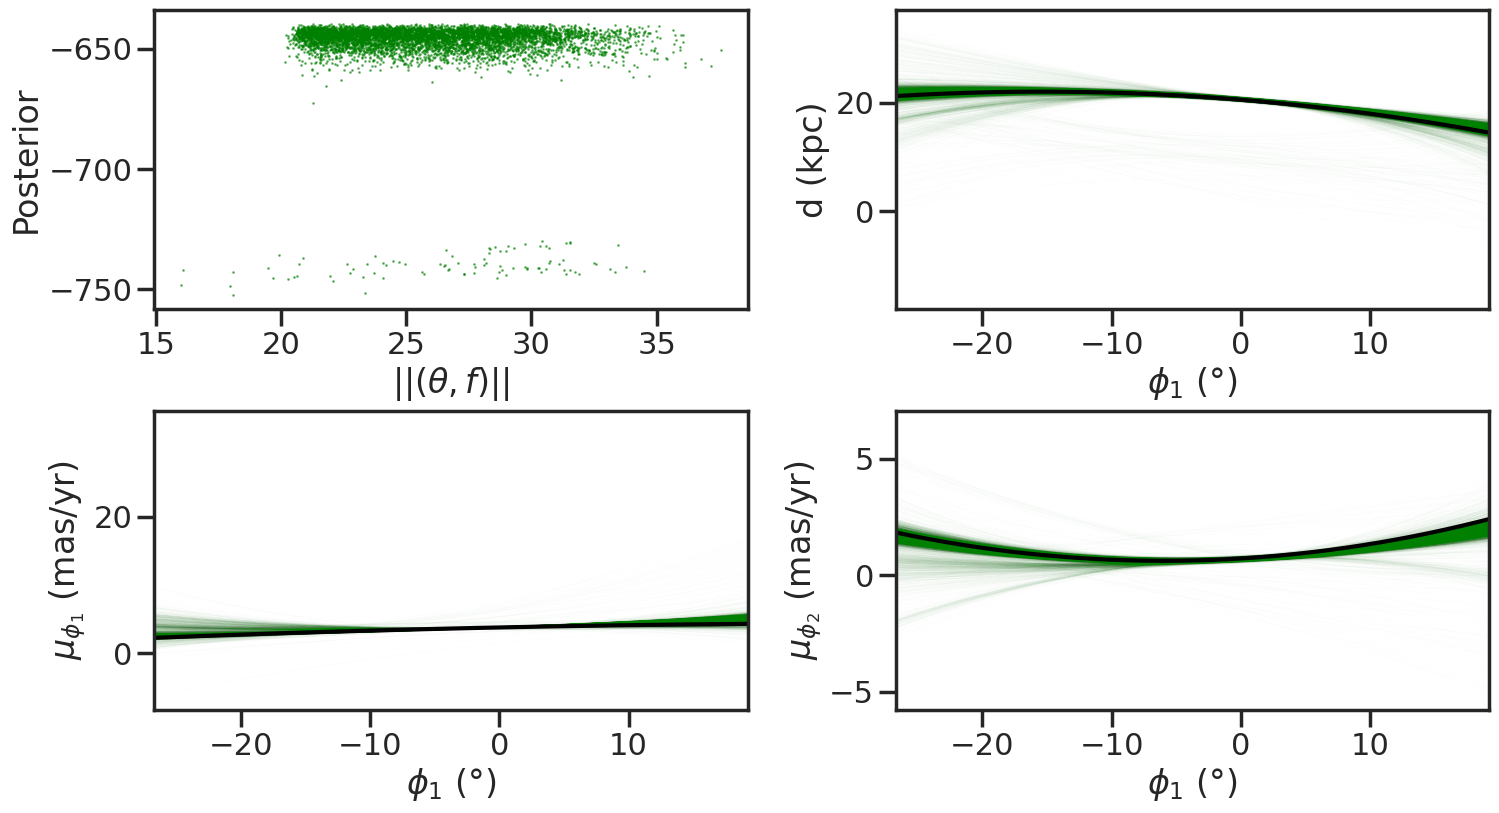

In [11]:
# mask_post = flat_samples[:,ndim]>-np.inf#-1150

fig4=plt.figure(4,figsize=(15,10))
fig4.subplots_adjust(wspace=0.25,hspace=0.34,top=0.95,bottom=0.25,left=0.09,right=0.98)

ax4=fig4.add_subplot(221)
for i in range(flat_samples[mask_post].shape[0]):
    ax4.plot(np.sqrt(np.sum(flat_samples[mask_post][i,:ndim]**2)), flat_samples[mask_post][i, ndim], '.', color='green', ms=2, alpha=0.5)
# ax4.plot(np.sqrt(np.sum(theta_true**2)), post_true, '.', color='black', ms=10)
# ax4.set_xlim([15,55])
ax4.set_xlabel('$||(\\theta,f)||$')
ax4.set_ylabel('Posterior')


ax4=fig4.add_subplot(222)
for i in range(flat_samples[mask_post].shape[0]):
    y_d = init.model(x, flat_samples[mask_post][i,2], flat_samples[mask_post][i,5], flat_samples[mask_post][i,8], flat_samples[mask_post][i,11])
    ax4.plot(x, y_d, lw=.5, color="green", zorder=1, alpha=0.01)

ax4.plot(x, true_d, lw=3, color="black", label='PW19', zorder=2)
ax4.set_xlim([min(phi1.value),max(phi1.value)])
# ax4.set_ylim([min(d),max(d)])
ax4.set_xlabel('$\phi_1$ (°)')
ax4.set_ylabel('d (kpc)')


ax4=fig4.add_subplot(223)
for i in range(flat_samples[mask_post].shape[0]):
    y_mu1 = init.model(x, flat_samples[mask_post][i,0], flat_samples[mask_post][i,3], flat_samples[mask_post][i,6], flat_samples[mask_post][i,9])
    ax4.plot(x, y_mu1, lw=.5, color="green", zorder=1, alpha=0.01)

ax4.plot(x, true_mu1, lw=3, color="black", label='PW19', zorder=2)
ax4.set_xlim([min(phi1.value),max(phi1.value)])
# ax4.set_ylim([min(pmphi1.value),max(pmphi1.value)])
ax4.set_xlabel('$\phi_1$ (°)')
ax4.set_ylabel('$\mu_{\phi_1}$ (mas/yr)')

ax4=fig4.add_subplot(224)
for i in range(flat_samples[mask_post].shape[0]):
    y_mu2 = init.model(x, flat_samples[mask_post][i,1], flat_samples[mask_post][i,4], flat_samples[mask_post][i,7], flat_samples[mask_post][i,10])
    ax4.plot(x, y_mu2, lw=.5, color="green", zorder=1, alpha=0.01)

ax4.plot(x, true_mu2, lw=3, color="black", label='PW19', zorder=2)

ax4.set_xlim([min(phi1.value),max(phi1.value)])
# ax4.set_ylim([min(pmphi2.value),max(pmphi2.value)]);
ax4.set_xlabel('$\phi_1$ (°)')
ax4.set_ylabel('$\mu_{\phi_2}$ (mas/yr)');

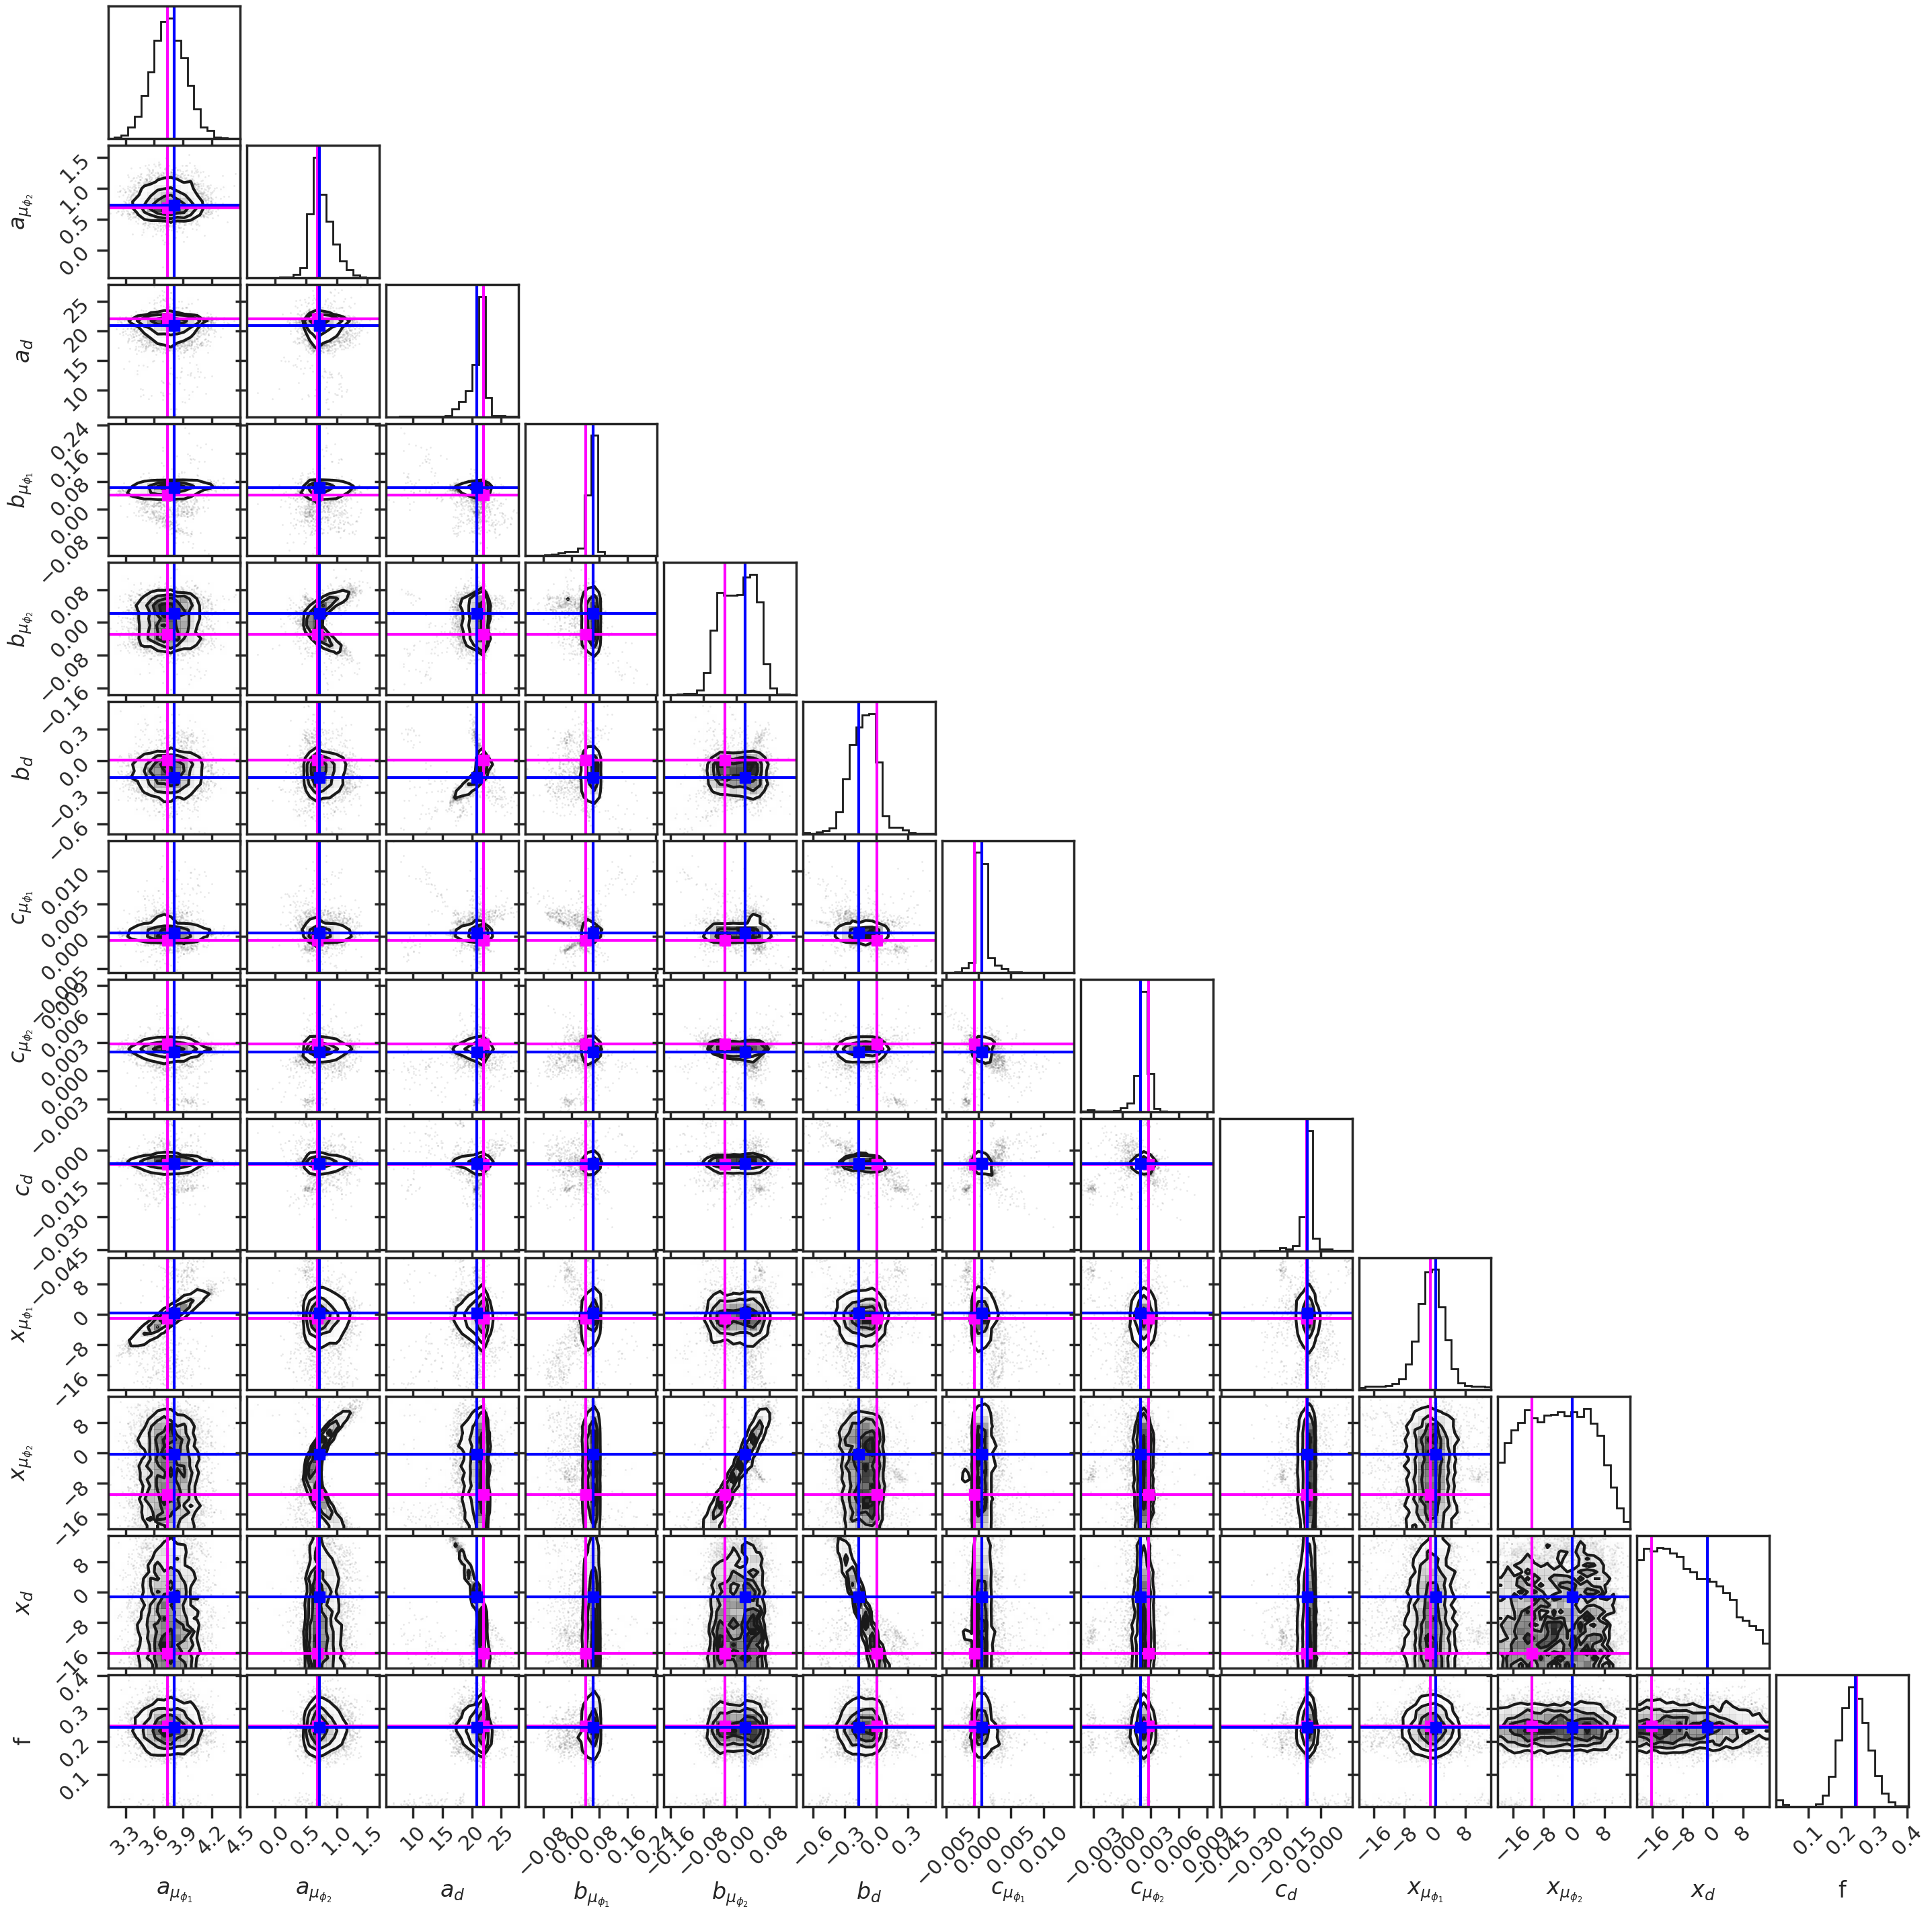

In [12]:
columns = ["$a_{\mu_{\phi_1}}$", "$a_{\mu_{\phi_2}}$", "$a_d$", "$b_{\mu_{\phi_1}}$", "$b_{\mu_{\phi_2}}$", "$b_d$", "$c_{\mu_{\phi_1}}$", "$c_{\mu_{\phi_2}}$", "$c_d$", "$x_{\mu_{\phi_1}}$", "$x_{\mu_{\phi_2}}$", "$x_d$", "f"]

fig2 = corner.corner(flat_samples[mask_post][:,0:13], labels=columns, labelpad=0.25, truths=theta_true, truth_color='magenta') #green
corner.overplot_lines(fig2, theta_max[0:13], color="blue") #blue
corner.overplot_points(fig2, theta_max[0:13][None], marker="s", color="blue")
fig2.subplots_adjust(bottom=0.05,left=0.05)

# fig2.savefig('corner_plot.png')

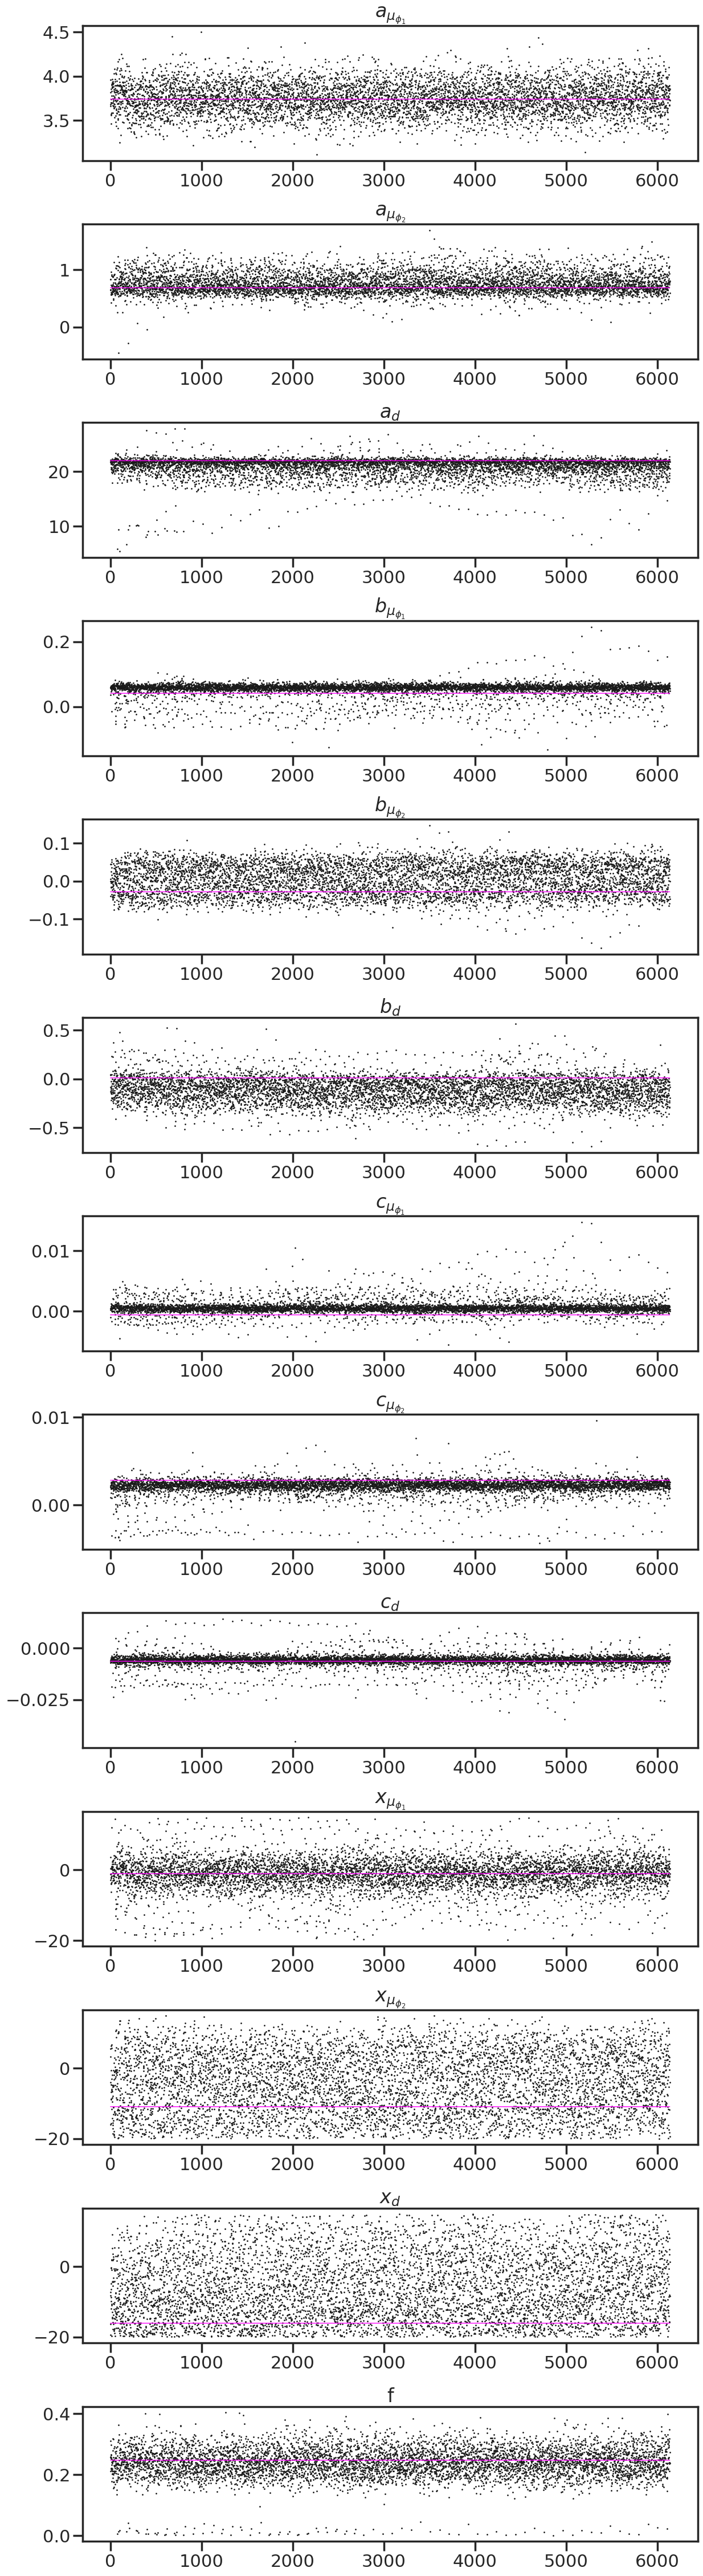

In [13]:
steps = np.arange(1,flat_samples.shape[0]+1)
N = np.arange(ndim)
columns = ["$a_{\mu_{\phi_1}}$", "$a_{\mu_{\phi_2}}$", "$a_d$", "$b_{\mu_{\phi_1}}$", "$b_{\mu_{\phi_2}}$", "$b_d$", "$c_{\mu_{\phi_1}}$", "$c_{\mu_{\phi_2}}$", "$c_d$", "$x_{\mu_{\phi_1}}$", "$x_{\mu_{\phi_2}}$", "$x_d$", "f"]

# mask_post = flat_samples[:,ndim]>-np.inf#1150

fig8=plt.figure(8,figsize=(12,ndim*3.5))
fig8.subplots_adjust(wspace=0.4,hspace=0.47,top=0.99,bottom=0.02,left=0.08,right=0.98)
for i in N:
    ax8=fig8.add_subplot(ndim,1,i+1)
    ax8.plot(steps[mask_post], flat_samples[mask_post][:,i], 'k.', ms=2)#, alpha=.5)
    ax8.plot(steps[~mask_post], flat_samples[~mask_post][:,i], '.', color='red', ms=2)#, alpha=.5)
    ax8.plot(steps, theta_true[i]*np.ones(flat_samples.shape[0]), '-', color='magenta', lw=1.)
    ax8.set_title(columns[i])

In [14]:
theta_resul = pd.DataFrame(columns = ["$a_{\mu1}$", "$a_{\mu2}$", "$a_d$", "$b_{\mu1}$", "$b_{\mu2}$", "$b_d$", "$c_{\mu1}$", "$c_{\mu2}$", "$c_d$", "$x_{\mu1}$", "$x_{\mu2}$", "$x_d$", "f", "Posterior"])
theta_resul.loc[0] = theta_max
theta_resul.loc[1] = theta_50
theta_resul.loc[2] = theta_qmin
theta_resul.loc[3] = theta_qmax
theta_resul.index = ['MAP','median','{}th'.format(q_lim[0]),'{}th'.format(q_lim[1])]
theta_resul

,$a_{\mu1}$,$a_{\mu2}$,$a_d$,$b_{\mu1}$,$b_{\mu2}$,$b_d$,$c_{\mu1}$,$c_{\mu2}$,$c_d$,$x_{\mu1}$,$x_{\mu2}$,$x_d$,f,Posterior
MAP,3.805644,0.724235,20.859556,0.062774,0.022361,-0.160102,0.000527,0.001956,-0.006076,0.314253,-0.404459,-1.296260,0.242810,-639.493742
median,3.746536,0.607199,20.981018,0.045827,0.020478,-0.051136,0.001828,0.002975,-0.009008,0.182612,0.351776,-2.765981,0.242753,-644.967733
5th,3.644020,0.649276,20.864869,0.024395,0.024836,0.247639,0.000720,0.003450,-0.014479,-3.151994,-2.542108,-16.439372,0.229321,-654.118963
95th,3.862568,0.737632,20.992010,0.059566,0.019335,-0.151069,0.000607,0.001913,-0.005050,0.486266,-0.489596,-2.657771,0.252499,-641.292712


In [ ]:
theta_true

array([ 3.7400e+00,  6.8600e-01,  2.2022e+01,  4.1020e-02, -2.8260e-02,
        9.4600e-03, -6.4230e-04,  2.8320e-03, -6.3270e-03, -1.0720e+00,
       -1.0954e+01, -1.6081e+01,  2.0000e-01])

In [ ]:
End = datetime.datetime.now()
print('Final: ', End, '\n')

In [ ]:
print(End-Start)

In [ ]:
tau = sampler.get_autocorr_time()
print('tau: ', tau)
print('tau promedio: {}'.format(np.mean(tau)))

In [ ]:
#Datos totales de gaiaDR3

from astropy.io import fits
from astropy.table import Table
import astropy.coordinates as ac
_ = ac.galactocentric_frame_defaults.set('v4.0') #set the default Astropy Galactocentric frame parameters to the values adopted in Astropy v4.0
import astropy.units as u
import gala.coordinates as gc
import galstreams
from pyia import GaiaData


mwsts = galstreams.MWStreams(verbose=False, implement_Off=True)


f = fits.open('globular_clusters_Vasiliev&Baumgardt2021.fit')
globs = f[1].data
skip_globs = globs[(globs['RAJ2000'] > ra_lim[0]) & (globs['RAJ2000'] < ra_lim[1]) & 
                       (globs['DEJ2000'] > dec_lim[0]) & (globs['DEJ2000'] < dec_lim[1]) &
                       (globs['Name'] != Name)]


def skip_mask(ra, dec):
    c1 = ac.SkyCoord(ra, dec)
    c2 = ac.SkyCoord(skip_globs['RAJ2000']*u.deg, skip_globs['DEJ2000']*u.deg)
    
    mask = np.ones(len(ra), dtype=bool)
    for c in c2:
        mask &= c1.separation(c) > 0.5*u.deg
    
    return mask



_tbl = Table.read('../gaiaDR3/masterv4.rrls.gapzo.gdr3-full.csv.gz', format='ascii.csv')
_tbl_dist = Table.read('../gaiaDR3/masterv4.rrls.gapzo.dist.short.csv.gz', format='ascii.csv');

_tbl['Dist'] = _tbl_dist['Dist']
_tbl['Dist_err'] = _tbl_dist['Dist_err']

g_all = GaiaData(_tbl)

d_lim = (10, 35)
g_all = g_all[(g_all.ra > ra_lim[0]*u.deg) & (g_all.ra < ra_lim[1]*u.deg) & 
              (g_all.dec > dec_lim[0]*u.deg) & (g_all.dec < dec_lim[1]*u.deg) & 
              skip_mask(g_all.ra, g_all.dec) & 
              (g_all.pmra.value!=1e20) & (g_all.pmdec.value != 1e20) & 
              (g_all.pmra.value != 0.) & (g_all.pmdec.value != 0.) & 
              (g_all.Dist > d_lim[0]) & (g_all.Dist < d_lim[1])
             ]

c_all = g_all.get_skycoord(distance=g_all.Dist*u.kpc, radial_velocity = np.zeros(len(g_all.Dist))*u.km/u.s)
c_all_pal5 = c_all.transform_to(mwsts[st].stream_frame)

phi1 = c_all_pal5.phi1
phi2 = c_all_pal5.phi2
d = g_all.Dist
e_d = g_all.Dist_err

pmphi1 = c_all_pal5.pm_phi1_cosphi2
pmphi2 = c_all_pal5.pm_phi2

y = np.array([pmphi1.value, pmphi2.value, d])

c_reflex = gc.reflex_correct(c_all)
st_coord_reflex = c_reflex.transform_to(mwsts[st].stream_frame)
pmphi1_reflex = st_coord_reflex.pm_phi1_cosphi2 #mas/yr
pmphi2_reflex = st_coord_reflex.pm_phi2 #mas/yr


pmra = g_all.pmra.value
pmdec = g_all.pmdec.value
e_pmra = g_all.pmra_error.value
e_pmdec = g_all.pmra_error.value
pmra_pmdec_corr = g_all.pmra_pmdec_corr


C_pm = [None for n in range(len(e_pmra))]  
for i in range(len(e_pmra)):
    C_pm[i] = np.array([[e_pmra[i]**2, e_pmra[i]*e_pmdec[i]*pmra_pmdec_corr[i]],
                        [e_pmra[i]*e_pmdec[i]*pmra_pmdec_corr[i], e_pmdec[i]**2]])
C_pm_radec = np.array(C_pm)
C_pm = gc.transform_pm_cov(c_all, C_pm_radec, mwsts[st].stream_frame) #Transformo matriz cov de pm al frame del stream
C_obs = np.zeros((len(e_pmra),3,3)) #Matriz de covarianza observacional en el frame del stream
C_obs[:,:2,:2] = C_pm
C_obs[:,2,2] = e_d**2

C_tot = C_int + C_obs

e_pmphi1 = np.array([C_obs[i][0,0]**0.5 for i in range(len(phi1))])
e_pmphi2 = np.array([C_obs[i][1,1]**0.5 for i in range(len(phi1))])

# C_obs_radec = np.zeros((len(pmra),3,3))
# C_obs_radec[:,:2,:2] = C_pm_radec
# C_obs_radec[:,2,2] = (d*0.03)**2


# gmm_name = 'gmm_bg'
# means = np.load(gmm_name + '_means.npy')
# covar = np.load(gmm_name + '_covariances.npy')
# gmm_best = GaussianMixture(n_components = len(means), covariance_type='full')
# gmm_best.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
# gmm_best.weights_ = np.load(gmm_name + '_weights.npy')
# gmm_best.means_ = means
# gmm_best.covariances_ = covar

# ll_bgn = gmm_best.score_samples(np.vstack([pmra, pmdec, d]).T) #ln_likelihood del fondo para cada estrella n
# np.save('ll_bgn_memb.npy', ll_bgn)
# ll_bgn = np.load('ll_bgn_memb.npy')

skypath = np.loadtxt('pal5_extended_skypath.icrs.txt')
skypath_N = ac.SkyCoord(ra=skypath[:,0]*u.deg, dec=skypath[:,1]*u.deg, frame='icrs')
skypath_S = ac.SkyCoord(ra=skypath[:,0]*u.deg, dec=skypath[:,2]*u.deg, frame='icrs')

# Concatenate N track, S-flipped track and add first point at the end to close the polygon (needed for ADQL)
on_poly = ac.SkyCoord(ra = np.concatenate((skypath_N.ra,skypath_S.ra[::-1],skypath_N.ra[:1])),
                        dec = np.concatenate((skypath_N.dec,skypath_S.dec[::-1],skypath_N.dec[:1])),
                        unit=u.deg, frame='icrs')

field = ac.SkyCoord(ra=g_all.ra, dec=g_all.dec, frame='icrs')
footprint = galstreams.get_mask_in_poly_footprint(on_poly, field, stream_frame=mwsts[st].stream_frame)


f = fits.open('RRLwithprobthin.fit')
data_PW = f[1].data
c = ac.ICRS(ra=data_PW['RA_ICRS']*u.degree, dec=data_PW['DE_ICRS']*u.degree, distance=data_PW['Dist']*u.kpc, pm_ra_cosdec=data_PW['pmRA']*u.mas/u.yr, pm_dec=data_PW['pmDE']*u.mas/u.yr, radial_velocity=np.zeros(len(data_PW['pmRA']))*u.km/u.s) 
st_coord = c.transform_to(mwsts[st].stream_frame)

miembro_PW = (data_PW['Track']==1) & (data_PW['Memb']>0.5)
# theta_true = np.array([3.740, 0.686, 22.022, 4.102e-2, -2.826e-2, 9.460e-3, -6.423e-4, 2.832e-3, -6.327e-3, -1.072, -10.954, -16.081, 0.2])

phi1_PW = st_coord.phi1[miembro_PW] #deg
phi2_PW = st_coord.phi2[miembro_PW] #deg
pmphi1_PW = st_coord.pm_phi1_cosphi2[miembro_PW] #mas/yr
pmphi2_PW = st_coord.pm_phi2[miembro_PW] #mas/yr
d_PW = data_PW[miembro_PW]['Dist'] #kpc

c_reflex = gc.reflex_correct(c)
st_coord_reflex = c_reflex.transform_to(mwsts[st].stream_frame)

pmphi1_reflex_PW = st_coord_reflex.pm_phi1_cosphi2 #mas/yr
pmphi2_reflex_PW = st_coord_reflex.pm_phi2 #mas/yr

field = ac.SkyCoord(ra=data_PW['RA_ICRS']*u.deg, dec=data_PW['DE_ICRS']*u.deg, frame='icrs')
footprint_PW = galstreams.get_mask_in_poly_footprint(on_poly, field, stream_frame=mwsts[st].stream_frame)

Initializing galstreams library from master_log... 
/home/bruno/anaconda3/lib/python3.9/site-packages/astropy/io/ascii/fastbasic.py:128: AstropyWarning: OverflowError converting to FloatType in column Dist_M18_sfdAG, possibly resulting in degraded precision.
  data, comments = self.engine.read(try_int, try_float, try_string)

/home/bruno/anaconda3/lib/python3.9/site-packages/astropy/io/ascii/fastbasic.py:128: AstropyWarning: OverflowError converting to FloatType in column Dist_M18_sfdAG_err, possibly resulting in degraded precision.
  data, comments = self.engine.read(try_int, try_float, try_string)

/home/bruno/anaconda3/lib/python3.9/site-packages/astropy/io/ascii/fastbasic.py:128: AstropyWarning: OverflowError converting to FloatType in column Dist, possibly resulting in degraded precision.
  data, comments = self.engine.read(try_int, try_float, try_string)

/home/bruno/anaconda3/lib/python3.9/site-packages/astropy/io/ascii/fastbasic.py:128: AstropyWarning: OverflowError converting 

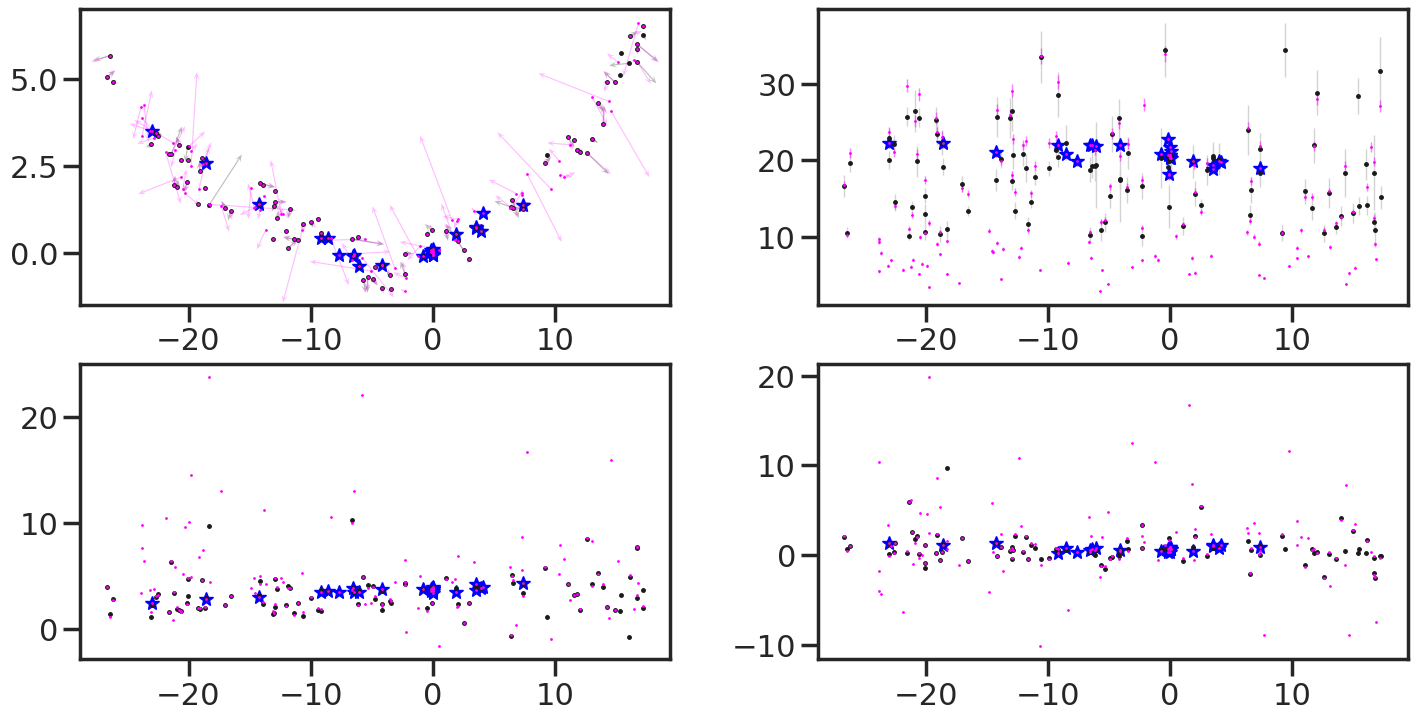

In [9]:
phi1_lim = (-27,17)
phi2_lim = (-3,7)

xy_mask = (phi1.value>=phi1_lim[0]) & (phi1.value<phi1_lim[1]) & (phi2.value>=phi2_lim[0]) & (phi2.value<=phi2_lim[1])
xy_mask_PW = (st_coord.phi1.value>=phi1_lim[0]) & (st_coord.phi1.value<phi1_lim[1]) & (st_coord.phi2.value>=phi2_lim[0]) & (st_coord.phi2.value<=phi2_lim[1])


fig=plt.figure(1,figsize=(15,10))    
fig.subplots_adjust(wspace=0.25,hspace=0.2,top=0.9,bottom=0.25,left=0.095,right=0.98)

ax=fig.add_subplot(221)
ax.plot(st_coord.phi1[miembro_PW], st_coord.phi2[miembro_PW], '*', c='blue', ms=10)
ax.plot(phi1[footprint & (d<35)], phi2[footprint & (d<35)], 'k.', ms=5)
ax.quiver(phi1[footprint & (d<35)].value, phi2[footprint & (d<35)].value, pmphi1_reflex[footprint & (d<35)].value, pmphi2_reflex[footprint & (d<35)].value, color='gray', width=0.002, headwidth=5, headlength=6.5, headaxislength=4, alpha=.5, scale=100)
ax.plot(st_coord.phi1[footprint_PW & (data_PW['Dist']<35)], st_coord.phi2[footprint_PW & (data_PW['Dist']<35)], '.', c='magenta', ms=2)
ax.quiver(st_coord.phi1[footprint_PW & (data_PW['Dist']<35)].value, st_coord.phi2[footprint_PW & (data_PW['Dist']<35)].value, pmphi1_reflex_PW[footprint_PW & (data_PW['Dist']<35)].value, pmphi2_reflex_PW[footprint_PW & (data_PW['Dist']<35)].value, color='magenta', width=0.002, headwidth=5, headlength=6.5, headaxislength=4, alpha=.25, scale=100)



ax=fig.add_subplot(222)
ax.plot(st_coord.phi1[miembro_PW & (data_PW['Dist']<35)], data_PW[miembro_PW & (data_PW['Dist']<35)]['Dist'], '*', c='blue', ms=10)
ax.errorbar(x=st_coord.phi1[miembro_PW & (data_PW['Dist']<35)], y=data_PW[miembro_PW & (data_PW['Dist']<35)]['Dist'], yerr=data_PW[miembro_PW & (data_PW['Dist']<35)]['Dist']*0.03, lw=0, elinewidth=1, color='magenta', alpha=0.5, zorder=0)
ax.plot(phi1[footprint & (d<35)], d[footprint & (d<35)], 'k.', ms=5)
ax.errorbar(x=phi1[footprint & (d<35)], y=d[footprint & (d<35)], yerr=e_d[footprint & (d<35)], lw=0, elinewidth=1, color='lightgray', zorder=0)
ax.plot(st_coord.phi1[footprint_PW & (data_PW['Dist']<35)], data_PW[footprint_PW & (data_PW['Dist']<35)]['Dist'], '.', c='magenta', ms=2)
ax.errorbar(x=st_coord.phi1[footprint_PW & (data_PW['Dist']<35)], y=data_PW[footprint_PW & (data_PW['Dist']<35)]['Dist'], yerr=data_PW[footprint_PW & (data_PW['Dist']<35)]['Dist']*0.03, lw=0, elinewidth=1, color='magenta', alpha=0.5, zorder=0)


ax=fig.add_subplot(223)
ax.plot(st_coord.phi1[miembro_PW & (data_PW['Dist']<35)], st_coord.pm_phi1_cosphi2[miembro_PW & (data_PW['Dist']<35)], '*', c='blue', ms=10)
ax.plot(phi1[footprint & (d<35)], pmphi1[footprint & (d<35)], 'k.', ms=5)
ax.errorbar(x=phi1[footprint & (d<35)].value, y=pmphi1[footprint & (d<35)].value, yerr=e_pmphi1[footprint & (d<35)], lw=0, elinewidth=1, color='lightgray', zorder=0)
ax.plot(st_coord.phi1[footprint_PW & (data_PW['Dist']<35)], st_coord.pm_phi1_cosphi2[footprint_PW & (data_PW['Dist']<35)], '.', c='magenta', ms=2)
# ax.errorbar(x=st_coord.phi1[footprint_PW & (data_PW['Dist']<35)], y=data_PW[footprint_PW & (data_PW['Dist']<35)]['Dist'], yerr=data_PW[footprint_PW & (data_PW['Dist']<35)]['Dist']*0.03, lw=0, elinewidth=1, color='magenta', alpha=0.5, zorder=0)
# ax.errorbar(x=st_coord.phi1[miembro_PW & (data_PW['Dist']<35)], y=data_PW[miembro_PW & (data_PW['Dist']<35)]['Dist'], yerr=data_PW[miembro_PW & (data_PW['Dist']<35)]['Dist']*0.03, lw=0, elinewidth=1, color='magenta', alpha=0.5, zorder=0)

ax=fig.add_subplot(224)
ax.plot(st_coord.phi1[miembro_PW & (data_PW['Dist']<35)], st_coord.pm_phi2[miembro_PW & (data_PW['Dist']<35)], '*', c='blue', ms=10)
ax.plot(phi1[footprint & (d<35)], pmphi2[footprint & (d<35)], 'k.', ms=5)
ax.errorbar(x=phi1[footprint & (d<35)].value, y=pmphi2[footprint & (d<35)].value, yerr=e_pmphi2[footprint & (d<35)], lw=0, elinewidth=1, color='lightgray', zorder=0)
ax.plot(st_coord.phi1[footprint_PW & (data_PW['Dist']<35)], st_coord.pm_phi2[footprint_PW & (data_PW['Dist']<35)], '.', c='magenta', ms=2)
# ax.errorbar(x=st_coord.phi1[footprint_PW & (data_PW['Dist']<35)], y=data_PW[footprint_PW & (data_PW['Dist']<35)]['Dist'], yerr=data_PW[footprint_PW & (data_PW['Dist']<35)]['Dist']*0.03, lw=0, elinewidth=1, color='magenta', alpha=0.5, zorder=0)
# ax.errorbar(x=st_coord.phi1[miembro_PW & (data_PW['Dist']<35)], y=data_PW[miembro_PW & (data_PW['Dist']<35)]['Dist'], yerr=data_PW[miembro_PW & (data_PW['Dist']<35)]['Dist']*0.03, lw=0, elinewidth=1, color='magenta', alpha=0.5, zorder=0)


- Hay estrellas de de DR2 que no están en DR3, incluso al menos 2 miembros

- Los valores de distancia de DR3 arrancan en 0, esto claramente no puede ser --> Tomo $d > 2$ kpc, ahora para Pal5 tomo $d > 10$ kpc para ver si mejora la inferencia acotando más el fondo

